In [2]:
from itertools import combinations

In [8]:
test_list = ["julia", "best", "tseb", "for", "ailuj"]
sum(a == b[::-1] for a, b in combinations(test_list, 2))
    

2

In [10]:
from collections import defaultdict
str1 = "data"
d = defaultdict(int)
for c in str1:
    d[c] += 1
max(d.items(), key=lambda x: x[1])[0]

In [14]:
max(d.items(), key=lambda x: x[1])[0]

'a'

In [1]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [766]:
import sys
import os
from collections import defaultdict, OrderedDict
import math

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [557]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPTNeoForCausalLM, GPT2Tokenizer
from utils import *

In [140]:
lines = open('/home/kf/projects/transformer-xl/checkpoints/tf/novelGpt2-ao3-100G-TPU512-mem384-dim1600-32layers-preLnorm/novelGpt2-ao3-100G-TPU512-mem384-dim1600-32layers-preLnorm-8-64-old.log').readlines()
a = [float(line.split()[line.split().index('ppl') + 2][:-1]) for line in lines if 'ppl' in line]

In [120]:
lines = open('/home/xd/b.out').readlines()
steps = [int(line.split()[line.split().index('step') + 2][:-1]) for line in lines]
a = [float(line.split()[line.split().index('ppl') + 2][:-1]) for line in lines]

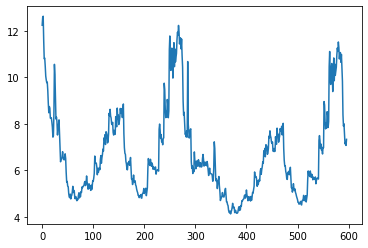

In [130]:
plt.plot(a[15:])

In [4]:
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
proxies = {'http': '192.168.50.1:1081'} 

In [5]:
device = torch.device('cpu')

In [12]:
model_name = 'gpt2-xl'  # medium / large / xl
model = GPT2LMHeadModel.from_pretrained(model_name, cache_dir=cache_dir)  
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)
models[model_name] = model, tokenizer

In cached_path: url_or_filename = https://huggingface.co/gpt2-xl/resolve/main/config.json
In cached_path: output_path = /nas/xd/.cache/torch/transformers/d2de8fec009fa9b9196047559bcac6c1f02a9c500718b4346bc516354965b1ca.81d9c13b9ee3f2b22faaba04ca49e09b13f9fea3a7910768ed6664ec141e3c8b
In cached_path: url_or_filename = https://huggingface.co/gpt2-xl/resolve/main/pytorch_model.bin
In cached_path: output_path = /nas/xd/.cache/torch/transformers/96569b907e56747ce3e593c6a13d8475b8c733a64aab8af8f602b90d94c4af71.8fbbcdf404c82c5967934d411f1462fa0574d639f2aa398aa3754fced1bb26c0
In cached_path: url_or_filename = https://huggingface.co/gpt2/resolve/main/vocab.json
In cached_path: output_path = /nas/xd/.cache/torch/transformers/684fe667923972fb57f6b4dcb61a3c92763ad89882f3da5da9866baf14f2d60f.c7ed1f96aac49e745788faa77ba0a26a392643a50bb388b9c04ff469e555241f
In cached_path: url_or_filename = https://huggingface.co/gpt2/resolve/main/merges.txt
In cached_path: output_path = /nas/xd/.cache/torch/transform

In [1014]:
# model, tokenizer, device = models['t5-11b']
# model, tokenizer, device = models['roberta-large']
# model, tokenizer, device = models['gpt2-xl']
# model, tokenizer, device = models['gpt2-medium']
# model, tokenizer, device = models['gpt2-large']

masked_lm = tokenizer.mask_token is not None and len(tokenizer.additional_special_tokens) == 0
if masked_lm:
    mask_token = tokenizer.mask_token  # '<mask>' for roberta
elif len(tokenizer.additional_special_tokens) > 0:
    mask_token = tokenizer.additional_special_tokens[0]  # '<sxtra_id_0>' for t5
else:
    mask_token = ''  # for gpt2
if masked_lm: nlp = pipeline('fill-mask', model=model, tokenizer=tokenizer, top_k=5)

Using mask_token, but it is not set yet.


In [1075]:
# model_name = 'EleutherAI/gpt-neo-2.7B'
model_name = 'gpt2-xl'
model, tokenizer = models[model_name]

In [1076]:
texts = [
 '''
10 5 6 -> 1
4 5 90 -> 9
40 9 5 -> 4
4 7 80 -> 8
3 4 60 -> 6
3 4 80 -> 8
6 70 4 -> 7
5 2 90 ->''',
]

_text = texts[0]#.lower()
# if '_' in _text: _text = texts.replace('_', mask_token).rstrip()

if masked_lm:
    print(_text, ['%s %.3f' % (i['token_str'], i['score']) for i in nlp(_text)])
    print(tokenizer.tokenize(_text))
else:
    inputs = tokenizer.encode_plus(_text, return_tensors='pt')
    inputs = tokenizer(_text, return_tensors="pt")
    inputs = prepare_inputs(inputs, model.device)
    max_length = 1 + (inputs['input_ids'].size(1) if mask_token == '' else 0)
    outputs = model.generate(**inputs, max_length=max_length, top_k=1)
#     print(_text)
    print(tokenizer.decode(outputs[0]))

    outputs = model(**inputs)
    logits = outputs.logits if hasattr(outputs, 'logits') else outputs[0]
    values, indices = logits[0, -1].softmax(dim=-1).topk(5)
    list(zip(tokenizer.convert_ids_to_tokens(indices), values.tolist()))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



10 5 6 -> 1
4 5 90 -> 9
40 9 5 -> 4
4 7 80 -> 8
3 4 60 -> 6
3 4 80 -> 8
6 70 4 -> 7
5 2 90 -> 9


[('Ġ9', 0.23945137858390808),
 ('Ġ10', 0.1267591416835785),
 ('Ġ8', 0.12185506522655487),
 ('Ġ6', 0.10871698707342148),
 ('Ġ7', 0.1033550277352333)]

In [10]:
model_name = "EleutherAI/gpt-neo-1.3B"
model = GPTNeoForCausalLM.from_pretrained(model_name, proxies=proxies, cache_dir=cache_dir)
tokenizer = GPT2Tokenizer.from_pretrained(model_name, cache_dir=cache_dir)
models[model_name] = model, tokenizer

In cached_path: url_or_filename = https://huggingface.co/EleutherAI/gpt-neo-1.3B/resolve/main/config.json
In cached_path: output_path = /nas/xd/.cache/torch/transformers/42252c2220ae3f9f1ea86a994b63e1dcab20953ba8982117c2384587f7c01c5d.0481f2d6b709486a0897fbfb2477d85f33e6a2843fd79a2261982c19c5b42624
In cached_path: url_or_filename = https://huggingface.co/EleutherAI/gpt-neo-1.3B/resolve/main/pytorch_model.bin
In cached_path: output_path = /nas/xd/.cache/torch/transformers/7c5fac9d60b015cbc7c007ab8fe6d0512787fbaef81968922959898c49468d73.4c6a483fbfb5a25ac384bfcd71a1ff15245f06583a00c4ab4c44ed0f761f0b08
In cached_path: url_or_filename = https://huggingface.co/EleutherAI/gpt-neo-1.3B/resolve/main/vocab.json
In cached_path: output_path = /home/xd/.cache/huggingface/transformers/6111bc9bbed617156dc5c0b9fa9d6793147619aad08053f03b3697f1a5027973.a1b97b074a5ac71fad0544c8abc1b3581803d73832476184bde6cff06a67b6bb
In cached_path: url_or_filename = https://huggingface.co/EleutherAI/gpt-neo-1.3B/resolve

In [11]:
# for Shawn Guo
model_name = "EleutherAI/gpt-neo-2.7B"
model = GPTNeoForCausalLM.from_pretrained(model_name, proxies=proxies, cache_dir=cache_dir)
tokenizer = GPT2Tokenizer.from_pretrained(model_name, cache_dir=cache_dir)
models[model_name] = model, tokenizer

In cached_path: url_or_filename = https://huggingface.co/EleutherAI/gpt-neo-2.7B/resolve/main/config.json
In cached_path: output_path = /nas/xd/.cache/torch/transformers/3c80ef2946e1aacc6dd37cb986ea989c29c92775701655bedf14d8791825a30b.180e94c8adf77aa69b51b48271e6cd2b143ce422d10bdefa9ace1512346c33c1
In cached_path: url_or_filename = https://huggingface.co/EleutherAI/gpt-neo-2.7B/resolve/main/pytorch_model.bin
In cached_path: output_path = /nas/xd/.cache/torch/transformers/0839a11efa893f2a554f8f540f904b0db0e5320a2b1612eb02c3fd25471c189a.a144c17634fa6a7823e398888396dd623e204dce9e33c3175afabfbf24bd8f56
In cached_path: url_or_filename = https://huggingface.co/EleutherAI/gpt-neo-2.7B/resolve/main/vocab.json


Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

In cached_path: output_path = /nas/xd/.cache/torch/transformers/d4455fdc7c8e2bcf94a0bfe134b748a93c37ecadb7b8f6b0eb508ffdd433a61e.a1b97b074a5ac71fad0544c8abc1b3581803d73832476184bde6cff06a67b6bb
In cached_path: url_or_filename = https://huggingface.co/EleutherAI/gpt-neo-2.7B/resolve/main/merges.txt


Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

In cached_path: output_path = /nas/xd/.cache/torch/transformers/5660be25091706bde0cfb60f17ae72c7a2aa40223d68954d4d8ffd1fc6995643.f5b91da9e34259b8f4d88dbc97c740667a0e8430b96314460cdb04e86d4fc435
In cached_path: url_or_filename = https://huggingface.co/EleutherAI/gpt-neo-2.7B/resolve/main/added_tokens.json
In cached_path: url_or_filename = https://huggingface.co/EleutherAI/gpt-neo-2.7B/resolve/main/special_tokens_map.json


Downloading:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

In cached_path: output_path = /nas/xd/.cache/torch/transformers/953b5ce47652cf8b6e945b3570bfa7621164c337e05419b954dbe0a4d16a7480.3ae9ae72462581d20e36bc528e9c47bb30cd671bb21add40ca0b24a0be9fac22
In cached_path: url_or_filename = https://huggingface.co/EleutherAI/gpt-neo-2.7B/resolve/main/tokenizer_config.json


Downloading:   0%|          | 0.00/200 [00:00<?, ?B/s]

In cached_path: output_path = /nas/xd/.cache/torch/transformers/57ccc3b8af045ea106fffa36bcc8b764e9702b5f4c1f7b3aad70ccfcaa931221.c31b6b7d3225be0c43bc0f8e5d84d03a8b49fdb6b9f6009bbfff1f9cc5ec18bc
In cached_path: url_or_filename = https://huggingface.co/EleutherAI/gpt-neo-2.7B/resolve/main/tokenizer.json


In [ ]:
# for Shawn Guo
for path in ['/nas/qsj/code/transformer-xl/pytorch/utils', '/nas/qsj/code/transformer-xl/pytorch']:
    if path not in sys.path:
        sys.path.insert(0, path)
# model_path = '/home/kf/projects/transformer-xl/checkpoints/torch/novelGpt2-ao3-100G-TPU512-mem384-dim1600-32layers-preLnorm/model.ckpt-700000*.bin'
model_path = '/nas2/xiaomeng/models/TPU512-mem384-dim1600-32layers-preLnorm/model.ckpt-850000.bin'
model = torch.load(open(model_path, 'rb'))
model.backward_compatible()
model = model.to(device)
_ = model.eval()
# model.reset_length(384, 0, 1280)
model.reset_length(2048, 0, 2048)

model_name = 'tr-xl-1.1B'
model.device = torch.device('cpu')
models[model_name] = model, tokenizer

In [134]:
model_path = '/home/kf/projects/transformer-xl/checkpoints/torch/novel-90G-TPU512-mem384-dim1536-36layers-preLnorm/model.ckpt-270000.bin'
model = torch.load(open(model_path, 'rb'))

/home/kf/miniconda3/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'mem_transformer.MemTransformerLM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [137]:
[(i, wm(layer.dec_attn.layer_norm), wm(layer.dec_attn.qkv_net), wm(layer.dec_attn.o_net), '---', 
  wm(layer.pos_ff.layer_norm), wm(layer.pos_ff.CoreNet[0]), wm(layer.pos_ff.CoreNet[3])) 
 for i, layer in enumerate(model.layers)]

[(0, 0.0981, 0.0945, 0.0795, '---', 0.1276, 0.0903, 0.0919),
 (1, 0.1926, 0.0916, 0.0771, '---', 0.2044, 0.0915, 0.0914),
 (2, 0.2064, 0.0933, 0.0794, '---', 0.3061, 0.0927, 0.0916),
 (3, 0.223, 0.0942, 0.0794, '---', 0.4141, 0.0935, 0.0915),
 (4, 0.2346, 0.0951, 0.0812, '---', 0.4984, 0.094, 0.0917),
 (5, 0.2676, 0.0963, 0.0813, '---', 0.5568, 0.0943, 0.0917),
 (6, 0.3005, 0.0951, 0.0824, '---', 0.6, 0.0946, 0.0917),
 (7, 0.3241, 0.0943, 0.0825, '---', 0.64, 0.0948, 0.0917),
 (8, 0.351, 0.0958, 0.0833, '---', 0.6598, 0.0949, 0.0917),
 (9, 0.3832, 0.0948, 0.0843, '---', 0.6898, 0.095, 0.0915),
 (10, 0.4281, 0.0939, 0.0834, '---', 0.7059, 0.0949, 0.0914),
 (11, 0.4071, 0.0947, 0.0844, '---', 0.7155, 0.0947, 0.0911),
 (12, 0.4165, 0.0948, 0.0872, '---', 0.7654, 0.095, 0.0914),
 (13, 0.4137, 0.0947, 0.0899, '---', 0.7846, 0.0951, 0.0915),
 (14, 0.4411, 0.0933, 0.0897, '---', 0.814, 0.0949, 0.0914),
 (15, 0.45, 0.0938, 0.0945, '---', 0.8274, 0.0949, 0.0913),
 (16, 0.4343, 0.0935, 0.0964, '

In [21]:
from vocabulary import NovelVocab, NovelGpt2Vocab

In [ ]:
base_dir = '/nas/qsj/respository/learning-test/transformer-xl/pytorch/model_cache/'
model_path = base_dir + 'big-model-100G-TPU1024-mem384-24layers-preLnorm-preemptible/model.pt'
model = torch.load(open(model_path, 'rb'))
model.backward_compatible()
model = model.to(device)
_ = model.eval()
model.reset_length(384, 0, 1280)
tokenizer = NovelVocab(base_dir + 'vocab_file.txt')

model_name = 'tr-xl-zh24l'
model.device = torch.device('cpu')
models[model_name] = model, tokenizer

In [157]:
base_dir = '/home/kf/projects/transformer-xl/checkpoints/torch/'
model_path = base_dir + 'novel-90G-TPU512-mem384-dim1536-36layers-preLnorm/model.ckpt-720000.bin'
model = torch.load(open(model_path, 'rb'))
model.backward_compatible()
model = model.to(device)
_ = model.eval()
model.reset_length(384, 0, 1280)
tokenizer = NovelVocab('/nas/qsj/code/transformer-xl/pytorch/model_cache/vocab_file_new.txt')

model_name = 'tr-xl-zh36l'
model.device = torch.device('cpu')
models[model_name] = model, tokenizer

/home/kf/miniconda3/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'mem_transformer.MemTransformerLM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [90]:
model_name = 'tr-xl-1.1B'
model, tokenizer = models[model_name]

In [39]:
model.layers[0].pos_ff.CoreNet[0]

Linear(in_features=1600, out_features=6400, bias=True)

In [41]:
def wm(param): return round(param.weight.abs().mean().item(), 4)

In [42]:
[(i, wm(layer.dec_attn.layer_norm), wm(layer.dec_attn.qkv_net), wm(layer.dec_attn.o_net), '---', 
  wm(layer.pos_ff.layer_norm), wm(layer.pos_ff.CoreNet[0]), wm(layer.pos_ff.CoreNet[3])) 
 for i, layer in enumerate(model.layers)]

[(0, 0.075, 0.1625, 0.1342, '---', 0.1443, 0.1519, 0.1502),
 (1, 0.1157, 0.1609, 0.1348, '---', 0.1991, 0.1522, 0.1495),
 (2, 0.1509, 0.1581, 0.1333, '---', 0.2806, 0.1516, 0.1481),
 (3, 0.2006, 0.1571, 0.1365, '---', 0.3573, 0.1517, 0.1484),
 (4, 0.2285, 0.1577, 0.1376, '---', 0.4287, 0.152, 0.1486),
 (5, 0.2758, 0.1542, 0.1409, '---', 0.4744, 0.152, 0.149),
 (6, 0.2819, 0.1542, 0.1434, '---', 0.5195, 0.1519, 0.1489),
 (7, 0.2875, 0.1532, 0.1499, '---', 0.5388, 0.1519, 0.1489),
 (8, 0.2808, 0.1529, 0.1523, '---', 0.5902, 0.152, 0.149),
 (9, 0.3142, 0.1519, 0.1543, '---', 0.6543, 0.1521, 0.1496),
 (10, 0.3342, 0.1515, 0.163, '---', 0.7048, 0.1524, 0.15),
 (11, 0.3262, 0.1519, 0.1613, '---', 0.7186, 0.1523, 0.1502),
 (12, 0.3313, 0.1526, 0.164, '---', 0.7507, 0.1525, 0.1505),
 (13, 0.3229, 0.1521, 0.167, '---', 0.7634, 0.1527, 0.1507),
 (14, 0.3248, 0.1517, 0.168, '---', 0.816, 0.1527, 0.151),
 (15, 0.3268, 0.1522, 0.1704, '---', 0.8372, 0.1526, 0.1509),
 (16, 0.3145, 0.152, 0.1704, '--

In [87]:
model_name = 'gpt2-xl'
model, tokenizer = models[model_name]

In [63]:
model.transformer.h[0]

GPT2Block(
  (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  (attn): GPT2Attention(
    (c_attn): Conv1D()
    (c_proj): Conv1D()
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (resid_dropout): Dropout(p=0.1, inplace=False)
  )
  (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  (mlp): GPT2MLP(
    (c_fc): Conv1D()
    (c_proj): Conv1D()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [64]:
[(i, wm(layer.ln_1), wm(layer.attn.c_attn), wm(layer.attn.c_proj), '---', 
  wm(layer.ln_2), wm(layer.mlp.c_fc), wm(layer.mlp.c_proj)) 
 for i, layer in enumerate(model.transformer.h)]

[(0, 0.0978, 0.0391, 0.0123, '---', 0.4133, 0.0285, 0.0212),
 (1, 0.3581, 0.0298, 0.0215, '---', 0.5312, 0.0304, 0.0255),
 (2, 0.4426, 0.03, 0.0221, '---', 0.6714, 0.0309, 0.0266),
 (3, 0.4759, 0.031, 0.0226, '---', 0.6935, 0.0311, 0.0275),
 (4, 0.5256, 0.0311, 0.0236, '---', 0.6904, 0.0311, 0.0277),
 (5, 0.5392, 0.0319, 0.0237, '---', 0.6896, 0.0311, 0.0276),
 (6, 0.5418, 0.0323, 0.0238, '---', 0.6907, 0.0311, 0.0276),
 (7, 0.5364, 0.0328, 0.0235, '---', 0.7011, 0.0311, 0.0275),
 (8, 0.5715, 0.033, 0.0239, '---', 0.7065, 0.0311, 0.0275),
 (9, 0.5763, 0.0336, 0.0235, '---', 0.7162, 0.0311, 0.0273),
 (10, 0.6045, 0.0333, 0.0246, '---', 0.7231, 0.0311, 0.0275),
 (11, 0.583, 0.0332, 0.0252, '---', 0.7286, 0.0311, 0.0275),
 (12, 0.6021, 0.0336, 0.0253, '---', 0.7347, 0.0311, 0.0275),
 (13, 0.6251, 0.033, 0.0257, '---', 0.7353, 0.0311, 0.0277),
 (14, 0.6106, 0.0333, 0.0259, '---', 0.7245, 0.031, 0.0278),
 (15, 0.6302, 0.0332, 0.0273, '---', 0.7188, 0.0311, 0.0277),
 (16, 0.6643, 0.0318, 0.0

In [71]:
model_name = 'EleutherAI/gpt-neo-1.3B'
model, tokenizer = models[model_name]

In [55]:
[(i, wm(layer.ln_1), wm(layer.attn.attention.q_proj), wm(layer.attn.attention.k_proj), wm(layer.attn.attention.v_proj), wm(layer.attn.attention.out_proj), '---', 
  wm(layer.ln_2), wm(layer.mlp.c_fc), wm(layer.mlp.c_proj)) 
 for i, layer in enumerate(model.transformer.h)]

[(0, 0.2656, 0.044, 0.0438, 0.0455, 0.0426, '---', 0.8917, 0.0551, 0.0405),
 (1, 0.4886, 0.0512, 0.0515, 0.0463, 0.0441, '---', 1.3031, 0.0582, 0.043),
 (2, 0.5846, 0.0461, 0.0469, 0.0505, 0.0474, '---', 1.3098, 0.0567, 0.0429),
 (3, 0.4617, 0.0428, 0.0424, 0.0567, 0.0469, '---', 1.0418, 0.0423, 0.0263),
 (4, 0.6966, 0.051, 0.0493, 0.0562, 0.0493, '---', 1.5204, 0.0601, 0.0432),
 (5, 0.7229, 0.0533, 0.052, 0.0537, 0.0495, '---', 1.7158, 0.0612, 0.0444),
 (6, 0.7553, 0.0543, 0.0539, 0.0522, 0.0503, '---', 1.6902, 0.0605, 0.0444),
 (7, 0.7578, 0.0549, 0.0537, 0.0536, 0.0516, '---', 1.433, 0.0588, 0.044),
 (8, 0.7471, 0.0486, 0.0493, 0.0573, 0.0543, '---', 1.4936, 0.0582, 0.0449),
 (9, 0.7453, 0.0457, 0.0449, 0.0629, 0.0603, '---', 1.311, 0.0574, 0.0459),
 (10, 0.8439, 0.046, 0.0469, 0.0657, 0.0624, '---', 1.3876, 0.0569, 0.047),
 (11, 0.7679, 0.0458, 0.0452, 0.0666, 0.0645, '---', 1.3403, 0.0566, 0.0487),
 (12, 0.753, 0.0452, 0.0457, 0.0644, 0.0639, '---', 1.3968, 0.0567, 0.0485),
 (13, 

In [56]:
model_name = 'EleutherAI/gpt-neo-2.7B'
model, tokenizer = models[model_name]
[(i, wm(layer.ln_1), wm(layer.attn.attention.q_proj), wm(layer.attn.attention.k_proj), wm(layer.attn.attention.v_proj), wm(layer.attn.attention.out_proj), '---', 
  wm(layer.ln_2), wm(layer.mlp.c_fc), wm(layer.mlp.c_proj)) 
 for i, layer in enumerate(model.transformer.h)]

[(0, 0.2835, 0.0356, 0.0356, 0.0349, 0.0329, '---', 0.9101, 0.045, 0.0321),
 (1, 0.4845, 0.04, 0.041, 0.0362, 0.0341, '---', 1.2614, 0.0477, 0.0334),
 (2, 0.632, 0.0393, 0.0401, 0.039, 0.0383, '---', 1.3314, 0.0469, 0.0337),
 (3, 0.5238, 0.0341, 0.0346, 0.0417, 0.0365, '---', 1.324, 0.0396, 0.0261),
 (4, 0.6214, 0.0377, 0.0366, 0.046, 0.039, '---', 1.3798, 0.0415, 0.0279),
 (5, 0.6594, 0.0411, 0.0408, 0.0425, 0.0379, '---', 1.5954, 0.0499, 0.0352),
 (6, 0.7038, 0.0427, 0.0428, 0.042, 0.0398, '---', 1.5804, 0.0498, 0.0356),
 (7, 0.7157, 0.044, 0.044, 0.0412, 0.0395, '---', 1.494, 0.0489, 0.0368),
 (8, 0.7216, 0.0421, 0.0429, 0.0425, 0.0416, '---', 1.514, 0.0488, 0.0364),
 (9, 0.7012, 0.0405, 0.0413, 0.0444, 0.0427, '---', 1.2791, 0.0479, 0.0363),
 (10, 0.7733, 0.0387, 0.0398, 0.0463, 0.0438, '---', 1.371, 0.0475, 0.0363),
 (11, 0.742, 0.0362, 0.0366, 0.0511, 0.049, '---', 1.2435, 0.0471, 0.0369),
 (12, 0.8328, 0.0371, 0.0382, 0.0526, 0.0504, '---', 1.2891, 0.0467, 0.0377),
 (13, 0.7251,

In [67]:
tgt_len, mem_len = 384, 1280

In [197]:
def infer(xl_model):
    def inner(data, *mems):
        if not mems: mems = xl_model.init_mems()
        # pdb.set_trace()
        hidden, new_mems = xl_model._forward(data, mems=mems)
        pro_layer = xl_model.crit
        hidden = pro_layer._compute_logit(hidden, pro_layer.out_layers[0].weight, pro_layer.out_layers[0].bias, pro_layer.out_projs[0])
        return [hidden] + new_mems
    return inner

In [69]:
data_dir = '/home/kf/data/formal_data/books3_cleaned/'
fnames = os.listdir(data_dir)
# fnames = [line.strip().replace('/mnt/nvme1/kf/data/formal_data/', '') 
#           for line in open(data_dir + 'allfile.filelist.shuffed.valid').readlines()
#           if 'ao3_General_Audiences_Teen_And_Up_selected/' in line]

In [178]:
def get_len(text, is_zh):
    if not is_zh: return len(text.split())
    else: return len(text)

In [636]:
def tokenize(tokenizer, text):
    eos_token = '&'
    eos_id = tokenizer.convert_text_to_ids(eos_token)[0]  # 111
    ids = tokenizer.convert_text_to_ids(text.replace('\n', eos_token))
    return [tokenizer.eos() if i == eos_id else i for i in ids]

In [770]:
from functools import reduce
def convert_text_to_ids(tokenizer, text):
    eos, eod = tokenizer.eos(), tokenizer.eod()
    ids = []
    for l in text.split("\n"):
        if l.strip() == '': continue
        ids += reduce(lambda x, y: x + [eod] + y, [tokenizer.convert_text_to_ids(s) for s in l.split('<eod>')]) + [eos]
    ids.pop()  # pos last eos
    return ids

def convert_ids_to_tokens(tokenizer, ids):
    return [token.replace('[unused10]', '/n') for token in tokenizer.convert_ids_to_tokens(ids)]

In [361]:
data_dir = ''
fnames = test_filepaths

In [953]:
is_zh = isinstance(tokenizer, NovelVocab)
# bad_books, good_books = [], []
# for fname in fnames:
# if True:

fname = random.choice(fnames)
print(fname)
lines = open(data_dir + fname).readlines()
print(fname, len(lines))

# i = random.randint(0, len(lines) - 30)
# text, _text = '', ''
# while get_len(text, is_zh=True) < 768 and i < len(lines) - 1:
#     text += lines[i]
#     if lines[i].strip() not in ['', '……', '…'] and '-分页-' not in lines[i]: _text += lines[i]
#     i += 1
# print('len(_text.split()) =', get_len(text, is_zh=True))

if is_zh:
    _text_lengths = [0, 1]
    while len(set(_text_lengths)) > 1:
        print('skip', _text_lengths)
        i = random.randint(0, len(lines) - 30)
        text, _text = '', ''
        while get_len(text, is_zh=True) < 1280 and i < len(lines) - 1:
            text += lines[i]
            line = lines[i].strip()
            if line not in ['', '……', '…'] and '-分页-' not in line and not line.isdigit():
                _text += line + '\n'
            i += 1
        _text_lengths = [len(convert_text_to_ids(tokenizer, _text)) 
                         for model_name, (model, tokenizer) in models.items() if 'zh' in model_name]
    input_len = _text_lengths[0]
    print('input_len =', input_len)
# else:
#     inputs = tokenizer(text, return_tensors="pt")
#     print('input_len =', inputs.input_ids.size(1))
#     input_ids = inputs.input_ids[:, -1024:]
#     shift_labels = input_ids.clone()[:, 1:]
#     shift_labels[:, :-tgt_len] = -100

#     if text != _text:
#         _inputs = tokenizer(_text, return_tensors="pt")
#         _input_ids = _inputs.input_ids[:, -1024:]
#         _shift_labels = _input_ids.clone()[:, 1:]
#         _shift_labels[:, :-tgt_len] = -100
tgt_len = 384

/elderberry_shared/69shuba/20210403_69shu_novel_dev1/13012-重生之诱君欢-似是故人来
/elderberry_shared/69shuba/20210403_69shu_novel_dev1/13012-重生之诱君欢-似是故人来 7339
skip [0, 1]
input_len = 1382


In [894]:
title, category = '', ''
text = '''明月几时有？把酒问青天。
不知天上宫阙，今夕是何年？
我欲乘风归去，又恐琼楼玉宇，高处不胜寒。
起舞弄清影，何似在人间？'''
# text = '''赵客缦胡缨，吴钩霜雪明。
# 银鞍照白马，飒沓如流星。
# 十步杀一人，千里不留行。
# 事了拂衣去，深藏身与名。'''
tgt_lengths = [len(convert_text_to_ids(tokenizer, text)) for model_name, (model, tokenizer) in models.items() if 'zh' in model_name]
assert len(set(tgt_lengths)) == 1, str(tgt_lengths)
tgt_len = tgt_lengths[0]

In [954]:
# for Shawn Guo
for _input_len in [768, ]:
    results = defaultdict(dict)
    for model_name, (model, tokenizer) in models.items():
        if is_zh and 'zh' not in model_name: continue
        if 'zh' in model_name:
    #         _prompt = padding_texts[model_name] % (title, category)
    #         _text = _prompt + text
            input_ids = torch.LongTensor([convert_text_to_ids(tokenizer, _text)[-_input_len:]])
        elif 'tr-xl' in model_name:
            input_ids = tokenizer(_text, return_tensors="pt").input_ids
        else:
            input_ids = tokenizer(text, return_tensors="pt").input_ids
        shift_labels = input_ids.clone()[:, 1:]
        shift_labels[:, :-tgt_len] = -100
        with torch.no_grad():
            logits = infer(model)(input_ids.t().to(model.device), *tuple())[0].permute(1, 0, 2) \
                if 'tr-xl' in model_name else model(input_ids.to(model.device))[0]
        shift_logits = logits[:, :-1, :]
        loss = CrossEntropyLoss(reduction='none')(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1).to(model.device))
        loss = loss[-tgt_len:]
        results[model_name]['logits'] = shift_logits[0, -tgt_len:].cpu()
        results[model_name]['labels'] = shift_labels[0, -tgt_len:].tolist()
        results[model_name]['loss'] = loss.cpu()
        results[model_name]['ppl'] = math.exp(loss.mean().item())
        print(model_name, 'ppl', results[model_name]['ppl'])
    print(results['tr-xl-zh24l']['ppl'] - results['tr-xl-zh36l']['ppl'])

tr-xl-zh24l ppl 7.4983679663759
tr-xl-zh36l ppl 6.787260554053457
0.711107412322443


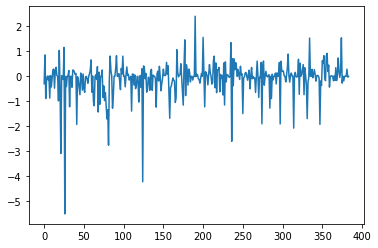

In [955]:
loss0, loss1 = results['tr-xl-zh24l']['loss'], results['tr-xl-zh36l']['loss']
dloss = loss1 - loss0
plt.plot(dloss)

In [956]:
th = 3
indices = (dloss.abs() > th).nonzero()[:, 0].tolist()
indices
loss0[(dloss.abs() > th)]
loss1[(dloss.abs() > th)]

[21, 26, 124]

tensor([9.9074, 6.2428, 8.6429])

tensor([6.8178, 0.7307, 4.4178])

In [957]:
[(i, ''.join(convert_ids_to_tokens(tokenizer, shift_labels[0, -tgt_len:][i - 2: i + 3].tolist()))) for i in indices]

[(21, '三绝吧？”'), (26, '/n冯侍郎有'), (124, '绝，床技无')]

In [960]:
for model_name in ['tr-xl-zh24l', 'tr-xl-zh36l']:
    model, tokenizer = models[model_name]
    logits, labels = results[model_name]['logits'], results[model_name]['labels']
    probs = logits.softmax(dim=-1)
    target_tokens = convert_ids_to_tokens(tokenizer, labels)
    print(model_name)
#     for i in range(tgt_len):
    for i in [21, 26, 124]:
        values, indices = probs[i].topk(5)
        values, indices = values.numpy().round(4), indices.tolist()
        print(i, target_tokens[i], dict(OrderedDict(zip(convert_ids_to_tokens(tokenizer, indices), values))))

tr-xl-zh24l
21 吧 {'，': 0.7278, '：': 0.0944, '。': 0.0747, '之': 0.0314, '-': 0.0212}
26 侍 {'丞': 0.9896, '侍': 0.0019, '家': 0.0006, '明': 0.0005, '氏': 0.0002}
124 床 {'就': 0.1123, '那': 0.1114, '能': 0.0956, '是': 0.0704, '便': 0.0505}
tr-xl-zh36l
21 吧 {'，': 0.5987, '。': 0.1186, '—': 0.0789, '：': 0.0585, '之': 0.0496}
26 侍 {'侍': 0.4816, '丞': 0.2717, '大': 0.0135, '府': 0.0119, '夫': 0.0114}
124 床 {'那': 0.1189, '是': 0.0567, '就': 0.0468, '能': 0.0435, '便': 0.0434}


In [958]:
print(_text)

看着熟悉又陌生的人，一瞬间，冯丞斐怀疑，自己眼睛花了，将另一个人看成禇明锦了。
禇明锦抬眼看到冯丞斐时，几乎要击掌大赞。
高挑秀逸的身材，宽大的月白广袖轻柔的垂着，随着微风吹动轻摆，袖口约一寸半宽的银色镶边上纹着暗光精美丝线，仿若浮云悄然飘动，又似淡月一样柔和。
往上，同样镶边云纹样的领口微微敞开，露出光滑精致的锁骨，优美的脖颈，再往上，是一张美得让禇明锦觉得世间所有的词语都不足以贴切地描述形容的脸，远山藏黛眉，绿水锁春波，丹唇点朱砂，如厮美貌，却又毫不娘气，整个人带给人的是一种蓝天白云的旷远悠然，高山流水的出尘离俗感觉。
此人容色如此秀美绝伦，会不会就是几个妹妹赞不绝口的冯侍郎？也即自己的挂名郎君？
冯丞斐在对上禇明锦的眼神后，心头的疑惑更深。
袍裾起伏，冯丞斐缓走几步，唇角微翘，带出一丝迷离的浅笑，朝禇明锦拱了拱手，道：“在下李怀瑾，公子风采，令人折服，不知可否同座？”
李怀瑾？这人不是冯丞斐。禇明锦略微缓得一缓，学着冯丞斐的样子拱手回礼，笑道：“幸会，李兄请坐。”
“有扰。”冯丞斐的笑容更深了，潇洒地撩起袍角，双腿盘膝坐了下去。
禇明锦此时方看清，对方身上的衣裳料子竟是雪蚕丝所织成的布，制作得非常精雅。这样的衣料，平常人穿不上，李姓据她所知是国姓，此人难道是哪个皇子或是王爷？
若是如此，这般样貌再加上身份尊贵，不至于给冯丞斐压下吧？为何没听几个妹妹提过？
伙计服务周到，茶杯茶点不需禇明锦开口便送过来了，冯丞斐伸了手握茶杯，长袖滑落，意态从容优雅，握着青花瓷杯的手指修-长匀称，指甲透明柔润，禇明锦微微眼直，脱口问道：“听闻冯侍郎有倾国倾城之貌，李兄与冯侍郎，未知谁高谁下？”
他的夫人问他，自己与自己比，谁高谁下？冯丞斐一口茶几乎喷出来，偏头看着禇明锦微微一笑，漫声道：“兄台这话让人好生难答，依兄所见呢？”
舒雅慵懒的靡丽语气，却并不让人反感，只因眼前之人，容色秀美高雅，污浊之气也因他而荡涤一空。
禇明锦笑道：“在下没见过冯侍郎，不过以李兄之貌，若是尚在冯侍郎之下，那冯侍郎，岂不是要羞煞神仙？倾倒世间所有男女？”
冯丞斐心道：羞煞神仙也许有可能，倾倒世间所有男女却未必，至少你就没被倾倒。
面对面坐着，又说了这么多话，冯丞斐很肯定，眼前之人是禇明锦无疑，她难道以为自己加浓了眉毛，抹了粉饼，稍为改变了声音，自己便认不出来？
冯丞斐起了作弄之心，笑道：“在下与冯侍郎是没

In [820]:
logits = results['tr-xl-zh36l']['logits']
i = 27
logits = logits[i: i + 1] 
logits.softmax(-1).topk(5)
logits = logits / 0.8
logits.softmax(-1).topk(5)

a = torch.ones(1, logits.size(1))
a[0, 2769] *= 1.2
logits = logits / a
logits.softmax(-1).topk(5)

logits = top_k_logits(logits, 10)
logits.softmax(-1).topk(5)
logits = top_p_logits(logits, 0.9)
logits.softmax(-1).topk(5)

torch.return_types.topk(
values=tensor([[0.4655, 0.1617, 0.0430, 0.0399, 0.0305]]),
indices=tensor([[2769, 1372, 6760,  671, 7309]]))

torch.return_types.topk(
values=tensor([[0.6350, 0.1693, 0.0324, 0.0295, 0.0211]]),
indices=tensor([[2769, 1372, 6760,  671, 7309]]))

torch.return_types.topk(
values=tensor([[0.4127, 0.1103, 0.0789, 0.0718, 0.0514]]),
indices=tensor([[1372, 2769, 6760,  671, 7309]]))

torch.return_types.topk(
values=tensor([[0.4746, 0.1268, 0.0907, 0.0826, 0.0591]]),
indices=tensor([[1372, 2769, 6760,  671, 7309]]))

torch.return_types.topk(
values=tensor([[0.5136, 0.1373, 0.0982, 0.0894, 0.0639]]),
indices=tensor([[1372, 2769, 6760,  671, 7309]]))

In [822]:
text[:15]

'明月几时有？把酒问青天。\n不知'

In [997]:
device = torch.device('cuda:1')
model = models['tr-xl-zh24l'][0]
model.device = device
_ = model.to(model.device)

In [1007]:
for model_name, (model, tokenizer) in models.items():
    if is_zh and 'zh' not in model_name: continue
    _prompt = padding_texts[model_name] #% (title, category)
    _text = _prompt #+ text[:15]
    input_ids = torch.LongTensor([convert_text_to_ids(tokenizer, _text)])
    if 'tr-xl' in model_name: input_ids = input_ids.t()
    reply = sample_sequence(infer(model), tokenizer, 10, input_ids.to(model.device), temperature=[1], top_k=[0], top_p=0.9, repeat=3, punishRate=1.2)
    print(model_name, len(convert_text_to_ids(tokenizer, _text)))
    for i in range(len(reply)):
        print(tokenizer.convert_ids_to_text(reply[i]).replace('[unused10]', '\n').replace('##', ''))
        print()

tr-xl-zh24l 371
完结感言
本书在这里说明一下
在这里要说的是，本书的前后两部分，第一部分《天价女友》，是一个非常精彩的故事，它的构思、设定都非常独特，我觉得我是在这部书里受益匪浅，也非常喜欢它，所以想写这样一部故事。
这里也要感谢作者编辑"无聊老头"大叔，他对这部小说给予了很多指导，让我有了写作的动力。当然这本书也是因为他给我的灵感，否则我也没有机会创造出这么一个世界，也不能写出这么一个精彩的故事，更不可能成为作家，也不可能在这里有这样的名字和地位。
感谢你们，也感谢这部书的每一个读者朋友，是你们支持我，才有今天的我。
各位朋友，来日再见！
<doc>
novelname:
qidiannovelcategories:完本,签约,vip
qidiannovelauthorcategories:%s
qidiannovelscore:9.5
qidiannovelrecommendtime:57周
前言
感谢大家来看我的新书，我会努力更新的，请大家支持我！
第一章开场（1）
.开场结束.外面。

完结感言
本书在这里说明一下
在这里要说的是，本书的前后两部分，第一部分《天价女友》，是一个非常精彩的故事，它的构思、设定都非常独特，我觉得我是在这部书里受益匪浅，也非常喜欢它，所以想写这样一部故事。
这里也要感谢作者编辑"无聊老头"大叔，他对这部小说给予了很多指导，让我有了写作的动力。当然这本书也是因为他给我的灵感，否则我也没有机会创造出这么一个世界，也不能写出这么一个精彩的故事，更不可能成为作家，也不可能在这里有这样的名字和地位。
感谢你们，也感谢这部书的每一个读者朋友，是你们支持我，才有今天的我。
各位朋友，来日再见！
<doc>
novelname:
qidiannovelcategories:完本,签约,vip
qidiannovelauthorcategories:%s
qidiannovelscore:9.5
qidiannovelrecommendtime:57周
前言
感谢大家来看我的新书，我会努力更新的，请大家支持我！
第一章开场（1）
花絮如梦！
我已经

完结感言
本书在这里说明一下
在这里要说的是，本书的前后两部分，第一部分《天价女友》，是一个非常精彩的故事，它的构思、设定都非常独特，我觉得我是在这部书里受益匪浅，也非常喜欢它，所以想

In [1000]:
tokenizer.convert_text_to_ids('qidiannovelcategories')
tokenizer.convert_text_to_ids('qidiannovel')

[11566, 9360, 9502, 11689, 8472, 10869, 10935, 10939]

[11566, 9360, 9502, 11689, 8472]

In [1005]:
padding_text = """完结感言
本书在这里说明一下
在这里要说的是，本书的前后两部分，第一部分《天价女友》，是一个非常精彩的故事，它的构思、设定都非常独特，我觉得我是在这部书里受益匪浅，也非常喜欢它，所以想写这样一部故事。
这里也要感谢作者编辑\"无聊老头\"大叔，他对这部小说给予了很多指导，让我有了灵感和动力>。当然这本书也是因为他给我的灵感才有的灵感，否则我也没有机会创造出这么一个世界，也不能写出这么一个精彩的故事，更不可能成为作家，也不可能>在这里有这样的名字和地位。
感谢你们，也感谢这部书的每一个读者朋友，是你们支持我，才有今天的我。
各位朋友，来日再见！
<doc>
Novelname:
qidiannovelcategories:完本,签约,vip
qidiannovelauthorcategories:
qidiannovelscore:9.5
qidiannovelrecommendtime:57周
前言
感谢大家来看我的新书，我会努力更新的，请大家支持我！
第一章 开场（1）
"""

padding_texts = {}
padding_texts['tr-xl-zh24l'] = """完结感言
本书在这里说明一下
在这里要说的是，本书的前后两部分，第一部分《天价女友》，是一个非常精彩的故事，它的构思、设定都非常独特，我觉得我是在这部书里受益匪浅，也非常喜欢它，所以想写这样一部故事。
这里也要感谢作者编辑\"无聊老头\"大叔，他对这部小说给予了很多指导，让我有了写作的动力。当然这本书也是因为他给我的灵感，否则我也没有机会创造出这么一个世界，也不能写出这么一个精彩的故事，更不可能成为作家，也不可能在这里有这样的名字和地位。
感谢你们，也感谢这部书的每一个读者朋友，是你们支持我，才有今天的我。
各位朋友，来日再见！
<doc>
Novelname:
qidiannovelcategories:完本,签约,vip
qidiannovelauthorcategories:%s
qidiannovelscore:9.5
qidiannovelrecommendtime:57周
前言
感谢大家来看我的新书，我会努力更新的，请大家支持我！
第一章 开场（1）
"""
padding_texts['tr-xl-zh36l'] = """完结感言
本书在这里说明一下
在这里要说的是，本书的前后两部分，第一部分《天价女友》，是一个非常精彩的故事，它的构思、设定都非常独特，我觉得我是在这部书里受益匪浅，也非常喜欢它，所以想写这样一部故事。
这里也要感谢作者编辑“无聊老头”大叔，他对这部小说给予了很多指导，让我有了写作的动力。当然这本书也是因为他给我的灵感，否则我也没有机会创造出这么一个世界，也不能写出这么一个精彩的故事，更不可能成为作家，也不可能在这里有这样的名字和地位。
感谢你们，也感谢这部书的每一个读者朋友，是你们支持我，才有今天的我。
各位朋友，来日再见！
<eod>novelname:
novelcategory:
novelwords:556k
novelstatus:连载中
第1章
"""

In [1006]:
padding_texts

{'tr-xl-zh24l': '完结感言\n本书在这里说明一下\n在这里要说的是，本书的前后两部分，第一部分《天价女友》，是一个非常精彩的故事，它的构思、设定都非常独特，我觉得我是在这部书里受益匪浅，也非常喜欢它，所以想写这样一部故事。\n这里也要感谢作者编辑"无聊老头"大叔，他对这部小说给予了很多指导，让我有了写作的动力。当然这本书也是因为他给我的灵感，否则我也没有机会创造出这么一个世界，也不能写出这么一个精彩的故事，更不可能成为作家，也不可能在这里有这样的名字和地位。\n感谢你们，也感谢这部书的每一个读者朋友，是你们支持我，才有今天的我。\n各位朋友，来日再见！\n<doc>\nNovelname:\nqidiannovelcategories:完本,签约,vip\nqidiannovelauthorcategories:%s\nqidiannovelscore:9.5\nqidiannovelrecommendtime:57周\n前言\n感谢大家来看我的新书，我会努力更新的，请大家支持我！\n第一章 开场（1）\n',
 'tr-xl-zh36l': '完结感言\n本书在这里说明一下\n在这里要说的是，本书的前后两部分，第一部分《天价女友》，是一个非常精彩的故事，它的构思、设定都非常独特，我觉得我是在这部书里受益匪浅，也非常喜欢它，所以想写这样一部故事。\n这里也要感谢作者编辑“无聊老头”大叔，他对这部小说给予了很多指导，让我有了写作的动力。当然这本书也是因为他给我的灵感，否则我也没有机会创造出这么一个世界，也不能写出这么一个精彩的故事，更不可能成为作家，也不可能在这里有这样的名字和地位。\n感谢你们，也感谢这部书的每一个读者朋友，是你们支持我，才有今天的我。\n各位朋友，来日再见！\n<eod>novelname:\nnovelcategory:\nnovelwords:556k\nnovelstatus:连载中\n第1章\n'}

In [576]:
def sample_batch(main_input, mems, sample_n):
    query_len, batch = main_input.size()
    assert batch == 1, str(batch)
    if batch != sample_n:
        main_input = main_input.expand(query_len, sample_n)
        def expand(m):
            return m.expand(m.size(0), sample_n, m.size(2))
        mems = tuple(expand(i) if type(i) not in [tuple, list] else (expand(i[0]), expand(i[1])) for i in mems)
    return main_input, mems

def sample_sequence(infer_func, tokenizer, length, text_ids=None,
                    temperature=[1], temperature_lens=[1024], top_k=[0], top_k_lens=[1024], 
                    top_p=0, punishRate=1.2, device='cuda', sample=True,
                    tgt_len=512, repeat=3, logger=None, debug=False):
    output = text_ids
    unk = tokenizer.unk()
    mems = tuple()
    input_size = text_ids.size(0)
    if input_size > tgt_len:
        chunk_input = torch.split(text_ids, tgt_len, dim=0)
        text_ids = chunk_input[-1]
        with torch.no_grad():
            for input_ in chunk_input[:-1]:
                ret = infer_func(input_, *mems)
                mems = ret[1:]

    with torch.no_grad():
        cur_temperature = temperature[0]
        cur_temperature_lens = temperature_lens[0]
        cur_index = 0

        top_k_index = 0
        cur_top_k = top_k[0]
        cur_top_k_lens = top_k_lens[0]

        binputs, bmems = sample_batch(text_ids, mems, repeat) # binputs.size: qlen, batch_size
        penalized_so_fars = [[] for i in range(repeat)]  # XD [list(tokenizer.convert_text_to_ids('-1')) for i in range(repeat)]
        output = output.expand(-1, repeat) # XD output.repeat(1, repeat)

        if debug == True:
            # Set the random seed manually for reproducibility.
            np.random.seed(0)
            torch.manual_seed(0)
            random.seed(0)
            torch.cuda.manual_seed(0)
            torch.cuda.manual_seed_all(0)

        for i in range(length):
            ret = infer_func(binputs, *bmems)
            logits, bmems = ret[0], ret[1:]

            if i >= cur_temperature_lens and cur_index < len(temperature_lens) - 1:
                cur_index += 1
                cur_temperature = temperature[cur_index]
                cur_temperature_lens = temperature_lens[cur_index]

            logits = logits[-1, :, :] / cur_temperature if i < cur_temperature_lens else logits[-1, :, :]
            logits[:, unk] = -float("inf") # size: batch, vocab_size
            if punishRate != 1.0:
                for b_ind in range(repeat):
                    if i == 0:
                        pre_tokens = output[:, b_ind].tolist()
                        for pre_token in pre_tokens:
                            if pre_token not in penalized_so_fars[b_ind]:
                                penalized_so_fars[b_ind].append(pre_token)
                        logits[b_ind, penalized_so_fars[b_ind]] /= punishRate
                    else:
                        pre_tokens = output[-1:, b_ind].tolist()
                        for pre_token in pre_tokens:
                            if pre_token not in penalized_so_fars[b_ind]:
                                penalized_so_fars[b_ind].append(pre_token)
                        logits[b_ind, penalized_so_fars[b_ind]] /= punishRate

            if i >= cur_top_k_lens and top_k_index < len(top_k) - 1:
                top_k_index += 1
                cur_top_k = top_k[top_k_index]
                cur_top_k_lens = top_k_lens[top_k_index]
            logits = top_k_logits(logits, k=cur_top_k) if i < cur_top_k_lens else top_k_logits(logits, k=1)
            if top_p > 0:
                logits = top_p_logits(logits, top_p, device=output.device)
            log_probs = F.softmax(logits, dim=-1)
            if sample:
                prev = torch.multinomial(log_probs, num_samples=1)
#                 print(log_probs, log_probs.size())
#                 print(prev, prev.size())
            else:
                _, prev = torch.topk(log_probs, k=1, dim=-1)
            binputs = prev.T
            output = torch.cat((output, prev.T), dim=0)
        result = [output[:, b_ind].tolist() for b_ind in range(repeat)]
    return result

def top_p_logits(logits, top_p, threshold=-float('Inf'), filter_value=-float("inf"), device=None):
    assert top_p > 0
    # Compute cumulative probabilities of sorted tokens
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    cumulative_probabilities = torch.cumsum(
        F.softmax(sorted_logits, dim=-1), dim=-1)

    # Remove tokens with cumulative probability above the threshold
    sorted_indices_to_remove = cumulative_probabilities > top_p
    # Shift the indices to the right to keep also the first token above the threshold
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :
                                                                 -1].clone()
    sorted_indices_to_remove[..., 0] = 0

    batch, vlen = logits.size()
    dim_shift = torch.arange(0, batch * vlen, vlen).unsqueeze(1).to(device)
    shift_sorted_indices = sorted_indices + dim_shift

    # Back to unsorted indices and set them to -infinity
    indices_to_remove = shift_sorted_indices[sorted_indices_to_remove]
    logits = logits.view(-1)
    logits[indices_to_remove] = filter_value
    logits = logits.view(batch, vlen)

    indices_to_remove = logits < threshold
    logits[indices_to_remove] = filter_value
    return logits

def top_k_logits(logits, k):
    if k == 0:
        return logits
    else:
        values = torch.topk(logits, k)[0]
        batch_mins = values[:, -1].view(-1, 1).expand_as(logits)
        return torch.where(logits < batch_mins, torch.ones_like(logits) * -1e10, logits)

In [100]:
model.h = []
with torch.no_grad():
    outputs = infer(model)(input_ids.t().to(model.device), *tuple())

In [105]:
h = model.h
[(i, h[i].std(), (h[i + 1] - h[i]).std()) for i in range(len(h) - 1)]

[(0, tensor(5.5987), tensor(7.6025)),
 (1, tensor(10.2144), tensor(5.7188)),
 (2, tensor(14.6231), tensor(8.1893)),
 (3, tensor(21.4703), tensor(7.4709)),
 (4, tensor(27.7487), tensor(6.4097)),
 (5, tensor(32.8273), tensor(4.8736)),
 (6, tensor(35.6842), tensor(5.7815)),
 (7, tensor(39.4510), tensor(7.1989)),
 (8, tensor(44.4999), tensor(8.8033)),
 (9, tensor(50.7340), tensor(7.2952)),
 (10, tensor(55.4423), tensor(7.9693)),
 (11, tensor(61.0670), tensor(6.7234)),
 (12, tensor(64.6895), tensor(7.1054)),
 (13, tensor(68.1650), tensor(7.0033)),
 (14, tensor(71.3439), tensor(8.0297)),
 (15, tensor(75.5502), tensor(7.7979)),
 (16, tensor(79.1198), tensor(8.3848)),
 (17, tensor(82.9650), tensor(8.8104)),
 (18, tensor(87.1567), tensor(8.9794)),
 (19, tensor(90.9538), tensor(10.2715)),
 (20, tensor(96.1590), tensor(12.2447)),
 (21, tensor(101.4405), tensor(14.7695)),
 (22, tensor(107.2525), tensor(16.8721)),
 (23, tensor(114.7952), tensor(19.2625)),
 (24, tensor(124.3836), tensor(18.6267)),
 

In [88]:
with torch.no_grad():
    outputs = model(input_ids.to(model.device), output_hidden_states=True)

In [89]:
h = outputs.hidden_states
[(i, h[i].std(), (h[i + 1] - h[i]).std()) for i in range(len(h) - 1)]

[(0, tensor(0.0380), tensor(0.5697)),
 (1, tensor(0.5732), tensor(0.5271)),
 (2, tensor(1.0049), tensor(0.4064)),
 (3, tensor(1.3114), tensor(0.3322)),
 (4, tensor(1.5061), tensor(0.3446)),
 (5, tensor(1.6678), tensor(0.3630)),
 (6, tensor(1.8270), tensor(0.3725)),
 (7, tensor(1.9951), tensor(0.5527)),
 (8, tensor(2.2182), tensor(0.7076)),
 (9, tensor(2.5876), tensor(0.6395)),
 (10, tensor(2.9889), tensor(0.5948)),
 (11, tensor(3.3889), tensor(0.5656)),
 (12, tensor(3.7718), tensor(0.5275)),
 (13, tensor(4.1098), tensor(0.4977)),
 (14, tensor(4.3973), tensor(0.5121)),
 (15, tensor(4.6723), tensor(0.4920)),
 (16, tensor(4.9094), tensor(0.4900)),
 (17, tensor(5.1064), tensor(0.5056)),
 (18, tensor(5.2823), tensor(0.5331)),
 (19, tensor(5.4394), tensor(0.5673)),
 (20, tensor(5.5810), tensor(0.5723)),
 (21, tensor(5.7075), tensor(0.5937)),
 (22, tensor(5.8304), tensor(0.6449)),
 (23, tensor(5.9800), tensor(0.6563)),
 (24, tensor(6.1246), tensor(0.7027)),
 (25, tensor(6.2951), tensor(0.7422

In [86]:
h = outputs.hidden_states
[(i, h[i].std(), (h[i + 1] - h[i]).std()) for i in range(len(h) - 1)]

[(0, tensor(0.0747), tensor(7.3432)),
 (1, tensor(7.3467), tensor(1.9436)),
 (2, tensor(9.1519), tensor(1.3266)),
 (3, tensor(9.9043), tensor(8.8011)),
 (4, tensor(14.3849), tensor(0.7851)),
 (5, tensor(14.3645), tensor(0.9697)),
 (6, tensor(14.4759), tensor(1.2821)),
 (7, tensor(15.1120), tensor(3.6007)),
 (8, tensor(15.8244), tensor(1.9169)),
 (9, tensor(16.9650), tensor(1.5871)),
 (10, tensor(17.5919), tensor(2.1751)),
 (11, tensor(18.9304), tensor(1.3076)),
 (12, tensor(19.0266), tensor(1.5120)),
 (13, tensor(19.7175), tensor(1.7031)),
 (14, tensor(20.5265), tensor(2.3869)),
 (15, tensor(21.9366), tensor(2.5495)),
 (16, tensor(23.2286), tensor(2.2050)),
 (17, tensor(24.5118), tensor(3.1435)),
 (18, tensor(26.1887), tensor(3.2419)),
 (19, tensor(28.4994), tensor(2.5456)),
 (20, tensor(28.9179), tensor(2.2949)),
 (21, tensor(29.8167), tensor(3.8301)),
 (22, tensor(28.4710), tensor(8.3605)),
 (23, tensor(23.3440), tensor(22.9552))]

In [360]:
test_filepaths = [
    '/elderberry_shared/69shuba/20210330_69shu_novel_hyy/6425-插翅难飞-阿陶陶',
    '/elderberry_shared/69shuba/20210330_69shu_novel_hyy/113689-不二之臣-不止是颗菜',
    '/elderberry_shared/69shuba/20210330_69shu_novel_hyy/9744-操练吧，教官！-浅问',
    '/elderberry_shared/69shuba/20210330_69shu_novel_hyy/117096-表小姐-吱吱',
    '/elderberry_shared/69shuba/20210403_69shu_novel_dev1/24523-等你仰望-易修罗',
    '/elderberry_shared/69shuba/20210403_69shu_novel_dev1/13012-重生之诱君欢-似是故人来',
    '/elderberry_shared/69shuba/20210330_69shu_novel_hyy/16811-盛世之初-梦见稻谷',
    '/elderberry_shared/69shuba/20210330_69shu_novel_hyy/31403-沉香如屑-苏寞',
    '/elderberry_shared/69shuba/20210330_69shu_novel_hyy/35358-穿越豪门贵妇-仓央央仓',
    '/elderberry_shared/69shuba/20210330_69shu_novel_hyy/18204-逆袭之好孕人生[反重生]-盈澈逝雪',
    '/elderberry_shared/69shuba/20210330_69shu_novel_hyy/7092-好色婶子-耕田的牛',
    '/elderberry_shared/69shuba/20210330_69shu_novel_dev1/64241-撒旦的挚爱逃妻-简简',
    '/elderberry_shared/69shuba/20210330_69shu_novel_hyy/55925-总裁，夫人又胎动了-贝小爱',
    '/elderberry_shared/69shuba/20210330_69shu_novel_hyy/6428-读者和主角绝逼是真爱-颓',
#     '/nas/xd/data/novels/bl_rel_examples/营业悖论.txt',
#     '/nas/xd/data/novels/bl_rel_examples/【BL】[现代都市]《针锋对决》作者：水千丞.txt',
]

In [372]:
print(text)

“We’ve got a problem. And since it may affect your arrival on Daa’Very, Captain Picard felt you should know about it.”

At the mention of his homeworld, Morgen’s attention turned up a notch. “I’m listening,” he said.

“The Enterprise has run into a subspace phenomenon,” Riker explained. “Something we’ve never encountered before.”

“Has it thrown us off course?” the Daa’Vit asked. The first officer shook his head. “No. Our course is

unchanged. But the phenomenon has got us traveling at warp factor nine point nine five.”

Morgen’s forehead ridged over. “What?”

Riker nodded. “I know how it sounds, sir. But it’s the truth.” The Daa’Vit gestured to one of the chairs. “Sit, Commander. Please.”

The human conformed to the request. Morgen sat across from him on a rather queer-looking couch-a stone-and-moss affair which had come from ship’s stores. “Now,” the Daa’Vit told him, “say that again.” Riker spread his hands. He went over the whole business, leaving nothing out. After all, it was Mor

In [210]:
_ = models['EleutherAI/gpt-neo-2.7B'][0].to('cuda:2')
_ = models['EleutherAI/gpt-neo-1.3B'][0].to('cuda:1')
_ = models['gpt2-xl'][0].to('cuda:0')
_ = models['Transformer-XL-1.1B'][0].to('cuda:1')
models['Transformer-XL-1.1B'][0].device = torch.device('cuda:1')

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 2048)
    (wpe): Embedding(2048, 2048)
    (drop): Dropout(p=0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0, inplace=False)
            (resid_dropout): Dropout(p=0, inplace=False)
            (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (out_proj): Linear(in_features=2048, out_features=2048, bias=True)
          )
        )
        (ln_2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=2048, out_features=8192, bias=True)
          (c_proj): Linear(in_fea